In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import kagglehub
import shutil
import os
import torch.optim.lr_scheduler as lrSched
from sklearn.metrics import confusion_matrix

### Import and move the dataset

In [3]:
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)


for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, './')



Path to dataset files: C:\Users\mathi\.cache\kagglehub\datasets\gpreda\chinese-mnist\versions\7


In [41]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is in 1 channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Use single values for grayscale
])


### Splitting the data in a train dataset (80%) and a test dataset (20%)

In [42]:
dataset = pd.read_csv('chinese_mnist.csv')


characters = dataset['character'].unique().tolist()
print(characters)
print(len(characters))

['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15


In [43]:
IMAGE_PATH = path + "/data/data/"
print("dataframe (index file) rows:", dataset.shape[0]) 
print("image files :", len(os.listdir(IMAGE_PATH)))
filenames = os.listdir(IMAGE_PATH)
filenames[0:5]

dataframe (index file) rows: 15000
image files : 15000


['input_100_10_1.jpg',
 'input_100_10_10.jpg',
 'input_100_10_11.jpg',
 'input_100_10_12.jpg',
 'input_100_10_13.jpg']

In [93]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir, transform=None):
        self.df = annotations_dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath = os.path.join(self.img_dir, self.df['file'][idx]) 
        img = Image.open(imgPath)

        # Ensure the image is in grayscale
        img = img.convert('L')  # Convert to grayscale if it's not already
        
        # Apply transformations if they are provided
        if self.transform:
            img = self.transform(img)
        
        # Convert image to tensor format
        imgAsT = torch.from_numpy(np.array(img)).float()

        # If the image is 2D (grayscale), add the channel dimension
        if imgAsT.ndimension() == 2:
            imgAsT = imgAsT.unsqueeze(0)  # Add channel dimension (shape becomes [1, 64, 64])

        # Normalize the image
        imgAsT = imgAsT / 255.0  # Normalize to [0, 1] if necessary (optional based on your transform)

        # Retrieve the label (code)
        label = self.df['code'][idx] - 1  # Subtract 1 to start the labels from 0

        return imgAsT, label


In [94]:
dataset['file'] = dataset[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataset.head(5)

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [95]:
imgPath =  os.path.join(IMAGE_PATH, dataset['file'][4000]) 
im = Image.open(imgPath)
print(im.mode)
im.size



L


(64, 64)

In [96]:
chineseNumbers = ChineseMNISTdataset(dataset, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length




15000

In [97]:
BATCH_SIZE = 64


train_size = int(0.8 * len(chineseNumbers))  # 80% for training
test_size = len(chineseNumbers) - train_size  # Remaining 20% for testing
train_data, test_data = random_split(chineseNumbers, [train_size, test_size])

len(train_data), len(test_data)


(12000, 3000)

In [98]:

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

len(train_loader), len(test_loader)


(188, 47)

In [99]:
# Checking the size of the first batch in the train_loader
for batch_idx, (X, y) in enumerate(train_loader):
    print(f"Batch {batch_idx} - X size: {X.size()}, y size: {y.size()}")
    break  # Only check the first batch


Batch 0 - X size: torch.Size([64, 1, 64, 64]), y size: torch.Size([64])


torch.Size([1, 64, 64])
9


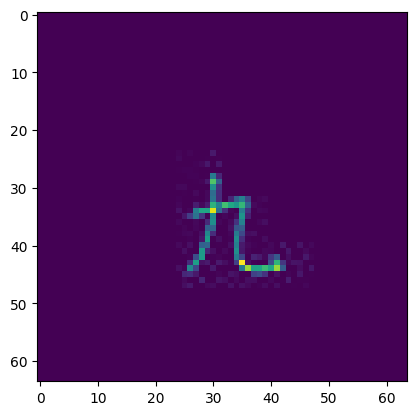

In [108]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)


img = img.squeeze(0).numpy()
plt.imshow(img)



In [101]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())  # Returns current device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


True
0
1
NVIDIA GeForce GTX 1060 3GB


In [102]:
class_names = ['0'  , '1'  , '2'  , '3'  , '4'  , '5'  , '6'  , '7'  , '8'  , '9'  , '10' , '100', '1000', '10000', '100000000']

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Output: (64, 64, 64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (128, 64, 64)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: (256, 64, 64)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Output: (512, 64, 64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces each dimension by half

        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjusted for 4x4 feature map size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 15)  # Output layer with 15 classes

        # Initialize weights (e.g., Xavier initialization for conv and linear layers)
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize convolution layers and fully connected layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 -> BatchNorm -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))  # Fully connected layer 1 with dropout
        x = self.dropout(F.relu(self.fc2(x)))  # Fully connected layer 2 with dropout
        x = self.fc3(x)  # Fully connected layer 3 (output)
        return x


In [104]:
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = lrSched.StepLR(optimizer, step_size = 30, gamma = 0.1)


In [ ]:
lossHistory = []
NUM_EPOCHS = 5


for e in range(NUM_EPOCHS):
    print(f"Epoch: {e+1}/{NUM_EPOCHS}")

    epochLoss = 0
    correct = 0
    totalExamples = 0
    trainLosses = []

    # Check to ensure train_loader is working properly
    if len(train_loader) == 0:
        print("Error: train_loader is empty!")
        break

    for batchIdx, (X, y) in enumerate(train_loader):
        # Ensure that batches are being retrieved and have the correct size
        if X.size(0) != BATCH_SIZE and batchIdx != len(train_loader) - 1:
            print(f"Warning: Batch size mismatch at batch {batchIdx}, expected {BATCH_SIZE} but got {X.size(0)}")
        
        # Move data to the device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        outputs = net(X)
        batchLoss = loss_function(outputs, y)  # Calculate the loss
        trainLosses.append(batchLoss.detach())  # Detach the loss to remove gradients

        # Backward pass
        batchLoss.backward()

        # Update model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Track the epoch loss
        epochLoss += batchLoss.item()

        # Print status every 50 batches
        if batchIdx % 50 == 0:
            totImages = batchIdx * BATCH_SIZE + len(X)
            print(f"\tIteration: {batchIdx}\t Current batch Loss: {batchLoss:.3f} | images: {totImages} | epoch loss/n: {epochLoss/len(train_loader):.3f}")

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        compare = y == preds
        correct += torch.sum(compare)
        totalExamples += len(compare)

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    accuracy = (correct / totalExamples).item()
    print(f"  Train epoch loss: {epochLoss:.2f} | mean: {torch.stack(trainLosses).mean().item():.2f} | accuracy: {accuracy:.2f} | lr: {scheduler.get_last_lr()}")
    lossHistory.append(torch.stack(trainLosses).mean().item())

print("Done!")


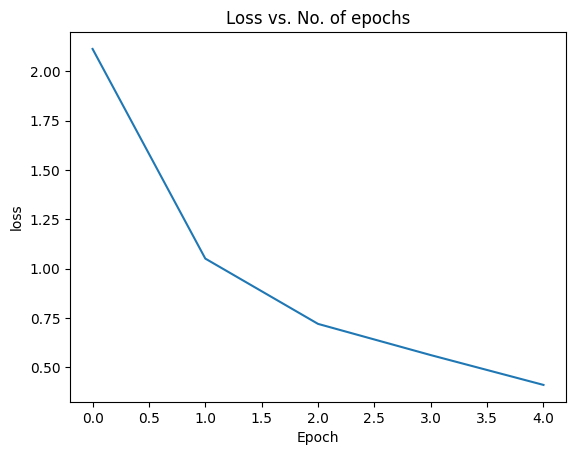

In [109]:
plt.plot(lossHistory)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

In [135]:
def computeAccuracy(model, data):
    model = model.eval()
    correct = 0.0
    totalExamples = 0
    totalLabels = np.array([])
    totalPred = np.array([])

    for idx, (features, labels) in enumerate(data):
        with torch.no_grad():
            features = features.to(device)
            labels = labels.to(device)
            logits = model(features) # run the model to get the predictions

        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions  # compare predictions with true label

        correct += torch.sum(compare)
        totalExamples += len(compare)

        totalLabels = np.concatenate((totalLabels, labels.cpu().numpy()))
        totalPred = np.concatenate((totalPred, predictions.cpu().numpy()))

    cm = confusion_matrix(totalLabels, totalPred)  # assemble the confusion matrix and print it
    print(f'Confusion matrix: \n{cm}')

    return (correct / totalExamples).item()  # return the accuracy

In [139]:
acc = computeAccuracy(net, test_loader)
print(f"\nAccuracy: {acc*100} %")


Confusion matrix: 
[[189   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0 175   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   5 197   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  25 164   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0 205   0   0   1   0   0   0   1   0   0   0]
 [  0   0   0   3   0 177   0   0   0   0   0   0   0   0   0]
 [  0   1   2   0   0   0 199   0   7   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0 196   0   1   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  17   0 176   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 214   0   0   0   0]
 [  0   0   0   0   2   5   0   0   1   0   0 181   2  18   0]
 [  0   0   0   0   0   0   0   3   0   0  29   0 184   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   8 199   0]
 [  0   0   0   0   3   0   0   0   1  38   0   0   0   0 168]]

Accuracy: 93.96666288375854 %


In [140]:
torch.save(net.state_dict(), 'trained_net.pth')

In [141]:
net = NeuralNet().to(device)
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

In [150]:
# TEST WITH ACTUAL IMAGES

new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def load_images(image_path):
    original_image = Image.open(image_path).convert('RGB')
    transformed_image = new_transform(original_image).unsqueeze(0)
    return original_image, transformed_image

image_paths = ['5.png','7.png','100.png','1000.jpg','10000.png']
images = [load_images(img) for img in image_paths]

net.eval()
with torch.no_grad():
    for image in images:

        # Get the output of the model
        output = net(image)

        # Get the predicted class
        _, predicted = torch.max(output, 1)

        print(predicted)




TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Image, Tensor)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Image, Tensor)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
